# Assignment 3

In this analysis five different datasets are selected from http://www.timeseriesclassification.com/. Several models are trained for each dataset. Two different representations each with two different parameter sets are used to build the model. Then, distances between the time series are calculated using 4 different distance measures. In the classification step, 3 different k values are used in the K-NN algorithm. Accuracy of each model is calculated to determine the best performing model. Finally, the best performing model is tested on a seperate test set.

In [ ]:
library(data.table)
library(ggplot2)
library(TSrepr)
library(caret)
library(TSdist)
library(dtw)
library(zoo)
library(rpart)
library(rattle)
require(TunePareto)

setwd("C:/Users/alpsr/Desktop/Assignment 3")

## Dataset 3: ECG200

In this notebook, Plane dataset is evaluated. This dataset contains 105 training time series and 105 test time series. There are 7 different classes. First six time series in the training dataset are as follows.

In [2]:
dataset = 'ECG200'
train_data_path=sprintf('%s/%s/%s_TRAIN.txt',getwd(),dataset,dataset)

In [3]:
ecg = fread(train_data_path)
ecg <- setnames(ecg, "V1", "Class")
ecg <- data.table(ecg)
ecg[, "ID" := 1:.N]
ecg[, "Class" := as.factor(Class)]
setcolorder(ecg, c("ID", "Class"))
colnames(ecg) <- c("ID", "Class",seq(1:96))
ecg_matrix <- as.matrix(ecg[,c(-1,-2)])
ecg_long <- melt(ecg,id.vars = c("ID","Class"))
ecg_long[,variable := as.numeric(variable)]
ecg_class <- ecg$Class
head(ecg)

ID,Class,1,2,3,4,5,6,7,8,...,87,88,89,90,91,92,93,94,95,96
<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1,0.5020555,0.5421626,0.7223835,1.4288852,2.13651580,2.2811490,1.93627370,1.4688900,...,0.93104294,0.6102984,0.6388943,0.68467857,0.58323764,0.6405217,0.70858515,0.70501088,0.7138155,0.4337646
2,1,0.1476469,0.8046684,0.3677715,0.2438937,0.02661388,-0.2744021,0.09673058,-0.7477306,...,-0.53350348,-0.4002281,0.1760841,1.11176800,2.43842820,2.7348886,1.73605440,0.03685655,-1.2650744,-0.2080244
3,-1,0.3166462,0.2431991,0.3704714,1.0637381,1.67818710,1.7595575,1.69771720,1.6121590,...,0.76422904,0.6106215,0.5529003,0.56678608,0.60400236,0.7770678,0.81234542,0.74884814,0.8180420,0.5393470
4,-1,1.1688741,2.0759008,1.7601405,1.6064459,1.94904560,1.3028421,0.45933154,0.5164121,...,0.41900645,0.7238876,1.3239469,2.13648760,1.74659650,1.4702205,1.89351230,1.25694930,0.8004066,0.7315398
5,1,0.6486575,0.7520260,2.6362312,3.4557156,2.11815740,0.5206202,-0.18862656,0.7808184,...,-0.09786878,-0.1367870,-0.3402367,-0.08944143,-0.08029728,-0.1925844,-0.30470444,-0.45455625,0.3145900,0.5821895
6,1,0.4047327,1.2808587,2.5151479,1.2995187,1.45343230,0.4742751,-1.39656190,-0.6470808,...,0.37646912,0.2778111,0.2256758,0.15909081,0.40835397,0.5400152,-0.02779116,0.20347623,0.3469639,0.3391847


## Classes

Two classes from the dataset are as follows.

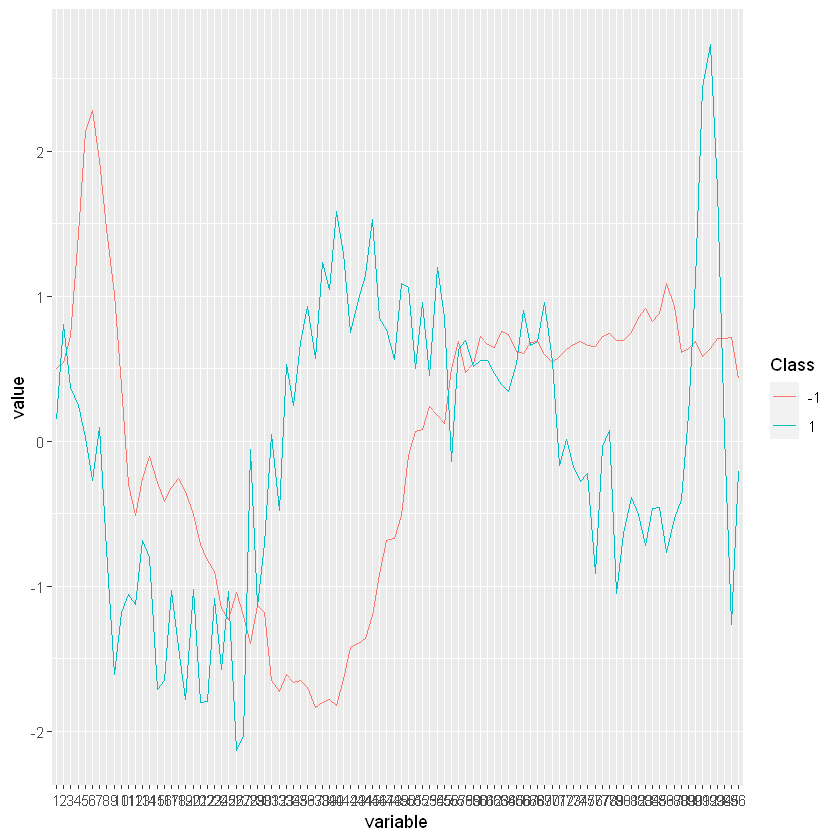

In [4]:
ecg_class_1 <- melt(ecg[,head(.SD, 1), Class],id.vars = c("ID","Class"))

ggplot(ecg_class_1, aes(x = variable, y = value, group = Class)) +
geom_line(aes(color = Class))

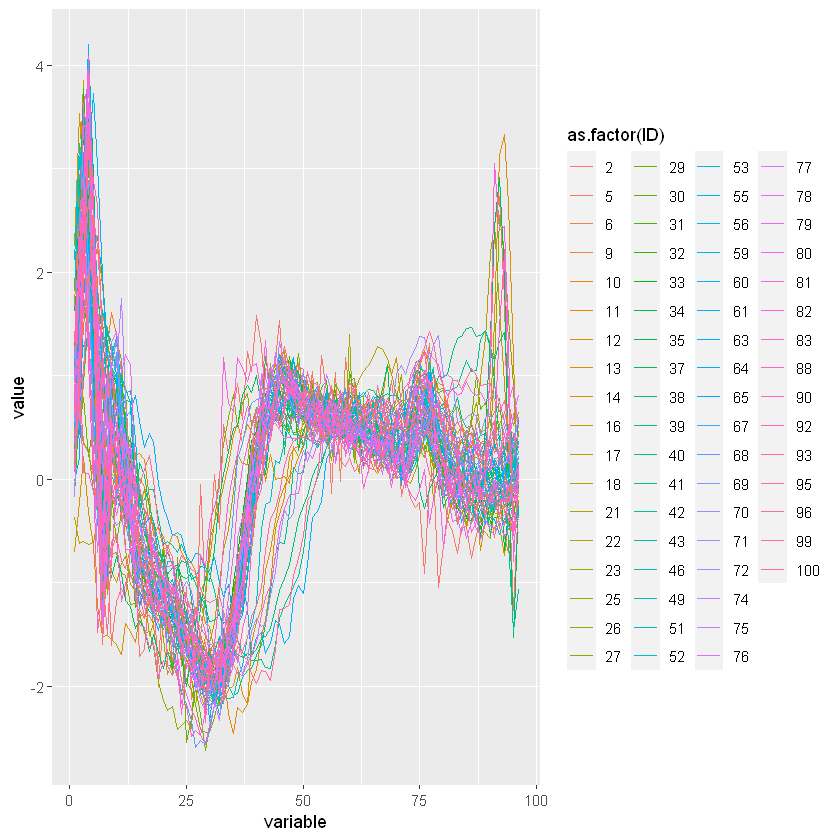

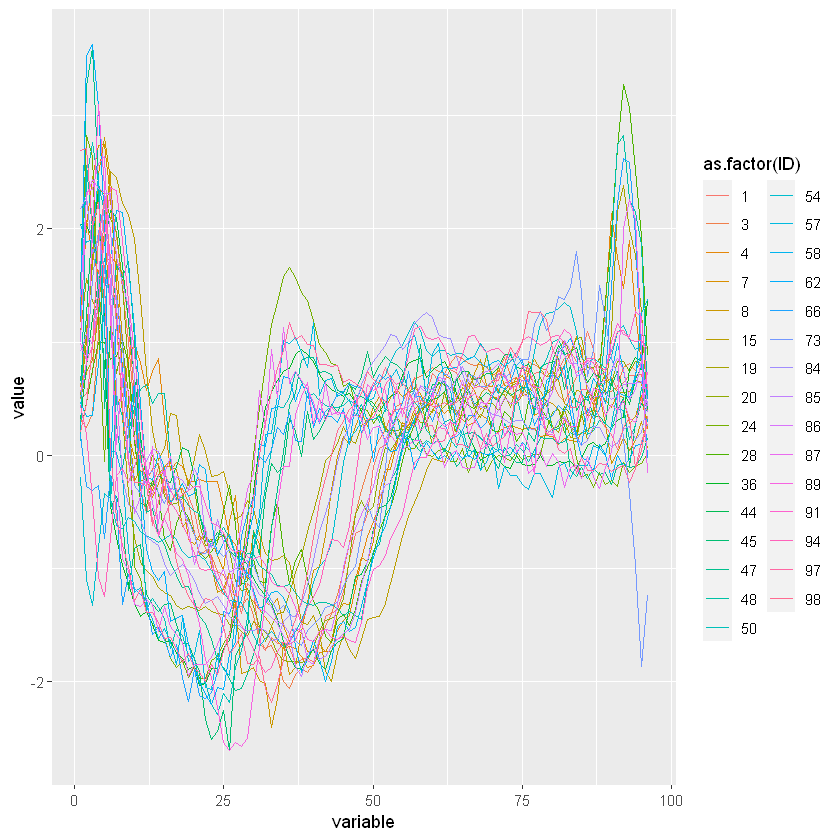

In [5]:
ggplot(ecg_long[Class == 1,], aes(x = variable, y = value, color = as.factor(ID))) +
geom_line()

ggplot(ecg_long[Class == -1,], aes(x = variable, y = value, color = as.factor(ID))) +
geom_line()

## Representations

Two different representations are used in this analysis. First one is SAX (symbolic aggregate approximation) and second is the APCA (Adaptive Piecewise Constant Approximation) using regression trees.

### Symbolic Aggregate Approximation

In [6]:
ecg_sax_q12 <- repr_matrix(ecg_matrix,repr_sax,args = list(q = 12, a = 5))
ecg_sax_q6 <- repr_matrix(ecg_matrix,repr_sax,args = list(q = 6, a = 5))

index1 = seq(1,95, by = 12)
for(i in seq(1,100)){
    ecg_long[(variable %in% index1) & (ID == i), SAX_q12 := ecg_sax_q12[i,]]
    ecg_long[ID == i, SAX_q12_fit := ecg_long[ID == i, na.locf(SAX_q12)]]
}

index2 = seq(1,95, by = 6)
for(i in seq(1,100)){
    ecg_long[(variable %in% index2) & (ID == i), SAX_q6 := ecg_sax_q6[i,]]
    ecg_long[ID == i, SAX_q6_fit := ecg_long[ID == i, na.locf(SAX_q6)]]
}

ecg_long[, SAX_q12_fit_value := mean(value), by = .(SAX_q12_fit,ID)]
ecg_long[, SAX_q6_fit_value := mean(value), by = .(SAX_q6_fit,ID)]

### Regression Trees

In [7]:
for(i in seq(1,100)){
    selected_series <- ecg_long[ID == i]
    tree_fit=rpart(value~variable,selected_series,control=rpart.control(maxdepth=3, cp = 0, minsplit = 20, minbucket = 10))
    #fancyRpartPlot(tree_fit)
    ecg_long[ID == i, Tree_fit_d3 := predict(tree_fit, selected_series)]
}

for(j in seq(1,100)){
    selected_series <- ecg_long[ID == j]
    tree_fit=rpart(value~variable,selected_series,control=rpart.control(maxdepth=4, cp = 0, minsplit = 20, minbucket = 10))
    #fancyRpartPlot(tree_fit)
    ecg_long[ID == j, Tree_fit_d4 := predict(tree_fit, selected_series)]
}

head(ecg_long)

ID,Class,variable,value,SAX_q12,SAX_q12_fit,SAX_q6,SAX_q6_fit,SAX_q12_fit_value,SAX_q6_fit_value,Tree_fit_d3,Tree_fit_d4
<int>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1,1,0.5020555,e,e,e,e,0.9663945,1.26885860,1.2407443,1.2407443
2,1,1,0.1476469,b,b,c,c,-0.4104650,0.03658984,-0.2124178,-0.2124178
3,-1,1,0.3166462,e,e,e,e,0.8460116,0.90529990,0.7116314,0.7116314
4,-1,1,1.1688741,e,e,e,e,1.1237407,1.48020617,1.1195829,1.1195829
5,1,1,0.6486575,e,e,e,e,1.1467244,1.34300090,1.1467244,1.1467244
6,1,1,0.4047327,d,d,e,e,0.4907039,1.06221561,0.4347167,0.4347167


## Distance Measures

Three different distances measures are used. First one is the Euclidean Distance. Remaining ones are Dynamic Time Warping (DTW), Longest Common Subsequence (LCSS) and Edit Distance with Real Penalties (ERP).

### Euclidean Distance

In [8]:
#ecg_matrix <- as.matrix(ecg[,c(-1,-2)]) #ncol = 144, nrow = 100, byrow = TRUE )
ecg_euclidean_raw <- as.matrix(dist(ecg_matrix))

ecg_SAX_q12_matrix <- dcast(ecg_long, ID + Class ~ variable, value.var = "SAX_q12_fit_value")
ecg_SAX_q6_matrix <- dcast(ecg_long, ID + Class ~ variable, value.var = "SAX_q6_fit_value")
ecg_RegTree_d3_matrix <- dcast(ecg_long, ID + Class ~ variable, value.var = "Tree_fit_d3")
ecg_RegTree_d4_matrix <- dcast(ecg_long, ID + Class ~ variable, value.var = "Tree_fit_d4")

ecg_euclidean_sax_q12 <- as.matrix(dist(as.matrix(ecg_SAX_q12_matrix[,c(-1,-2)])))
ecg_euclidean_sax_q6 <- as.matrix(dist(as.matrix(ecg_SAX_q6_matrix[,c(-1,-2)])))
ecg_euclidean_RegTree_d3 <- as.matrix(dist(as.matrix(ecg_RegTree_d3_matrix[,c(-1,-2)])))
ecg_euclidean_RegTree_d4 <- as.matrix(dist(as.matrix(ecg_RegTree_d4_matrix[,c(-1,-2)])))

### Dynamic Time Warping

In [9]:
ecg_dtw_sax_q12 <- as.matrix(TSDatabaseDistances(X = ecg_SAX_q12_matrix[,c(-1,-2)], distance = 'dtw'))
ecg_dtw_sax_q6 <- as.matrix(TSDatabaseDistances(X = ecg_SAX_q6_matrix[,c(-1,-2)], distance = 'dtw'))
ecg_dtw_RegTree_d3 <- as.matrix(TSDatabaseDistances(X = ecg_RegTree_d3_matrix[,c(-1,-2)], distance = 'dtw'))
ecg_dtw_RegTree_d4 <- as.matrix(TSDatabaseDistances(X = ecg_RegTree_d4_matrix[,c(-1,-2)], distance = 'dtw'))
ecg_dtw_raw <- as.matrix(TSDatabaseDistances(X = ecg_matrix, distance = 'dtw'))

### LCSS

In [10]:
ecg_lcss_raw <- as.matrix(TSDatabaseDistances(X = ecg_matrix, distance = 'lcss', epsilon = 0.1))
ecg_lcss_sax_q12 <- as.matrix(TSDatabaseDistances(X = ecg_SAX_q12_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
ecg_lcss_sax_q6 <- as.matrix(TSDatabaseDistances(X = ecg_SAX_q6_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
ecg_lcss_RegTree_d3 <- as.matrix(TSDatabaseDistances(X = ecg_RegTree_d3_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
ecg_lcss_RegTree_d4 <- as.matrix(TSDatabaseDistances(X = ecg_RegTree_d4_matrix[,c(-1,-2)], distance = 'lcss', epsilon = 0.1))
#str(ecg_lcss_sax_q12)

### ERP

In [11]:
ecg_erp_raw <- as.matrix(TSDatabaseDistances(X = ecg_matrix, distance = 'erp', g = 0))
ecg_erp_sax_q12 <- as.matrix(TSDatabaseDistances(X = ecg_SAX_q12_matrix[,c(-1,-2)], distance = 'erp', g = 0))
ecg_erp_sax_q6 <- as.matrix(TSDatabaseDistances(X = ecg_SAX_q6_matrix[,c(-1,-2)], distance = 'erp', g = 0))
ecg_erp_RegTree_d3 <- as.matrix(TSDatabaseDistances(X = ecg_RegTree_d3_matrix[,c(-1,-2)], distance = 'erp', g = 0))
ecg_erp_RegTree_d4 <- as.matrix(TSDatabaseDistances(X = ecg_RegTree_d4_matrix[,c(-1,-2)], distance = 'erp', g = 0))
#str(ecg_erp_sax_q12)

## Generating Runs

After building the distance matrices, each model's performance is measured using the 10-fold stratified cross validation with 5 repeats.

### Cross-Validation Runs

In [12]:
set.seed(12435)
cv_indices = generateCVRuns(ecg_class, ntimes = 5, nfold = 10, 
                            leaveOneOut = FALSE, stratified = TRUE)
str(cv_indices)

List of 5
 $ Run  1:List of 10
  ..$ Fold  1 : int [1:10] 84 20 44 98 39 64 21 51 95 37
  ..$ Fold  2 : int [1:10] 97 91 87 42 30 59 67 69 34 99
  ..$ Fold  3 : int [1:10] 85 58 45 29 88 9 92 56 100 82
  ..$ Fold  4 : int [1:10] 54 86 48 16 40 13 61 46 25 27
  ..$ Fold  5 : int [1:10] 1 66 19 93 52 96 38 79 74 80
  ..$ Fold  6 : int [1:10] 15 62 8 33 68 31 77 26 83 5
  ..$ Fold  7 : int [1:10] 73 57 89 70 60 76 53 10 90 81
  ..$ Fold  8 : int [1:10] 24 4 3 71 23 18 14 43 32 75
  ..$ Fold  9 : int [1:10] 28 7 94 11 35 6 78 22 55 2
  ..$ Fold  10: int [1:10] 50 36 47 65 12 63 17 72 49 41
 $ Run  2:List of 10
  ..$ Fold  1 : int [1:10] 97 19 89 94 42 12 52 6 33 55
  ..$ Fold  2 : int [1:10] 66 57 4 21 23 37 53 76 56 35
  ..$ Fold  3 : int [1:10] 50 58 45 75 63 49 13 18 68 81
  ..$ Fold  4 : int [1:10] 1 91 20 22 31 100 95 64 41 27
  ..$ Fold  5 : int [1:10] 54 62 98 26 46 40 88 29 99 38
  ..$ Fold  6 : int [1:10] 3 86 84 72 11 9 71 30 60 51
  ..$ Fold  7 : int [1:10] 7 8 85 17 77 78 74 2 

### k-NN Classifier

In [13]:
nn_classify_cv=function(dist_matrix,train_class,test_indices,k=1){
    
    test_distances_to_train=dist_matrix[test_indices,]
    test_distances_to_train=test_distances_to_train[,-test_indices]
    train_class=train_class[-test_indices]
    ordered_indices=apply(test_distances_to_train,1,order)
    
    if(k==1){
        nearest_class=as.numeric(train_class[as.numeric(ordered_indices[1,])])
        nearest_class=data.table(id=test_indices,nearest_class)
    } else {
        nearest_class=apply(ordered_indices[1:k,],2,function(x) {train_class[x]})
        nearest_class=data.table(id=test_indices,t(nearest_class))
    }
    
    long_nn_class=melt(nearest_class,'id')

    class_counts=long_nn_class[,.N,list(id,value)]
    class_counts[,predicted_prob:=N/k]
    wide_class_prob_predictions=dcast(class_counts,id~value,value.var='predicted_prob')
    wide_class_prob_predictions[is.na(wide_class_prob_predictions)]=0
    class_predictions=class_counts[,list(predicted=value[which.max(N)]),by=list(id)]
    
    
    return(list(prediction=class_predictions,prob_estimates=wide_class_prob_predictions))
    
}

### Testing the Models

In [14]:
#approach_file=list.files(dist_folder)
dist = list(ecg_euclidean_raw,
            ecg_euclidean_sax_q12,
            ecg_euclidean_sax_q6,
            ecg_euclidean_RegTree_d3,
            ecg_euclidean_RegTree_d4,
            ecg_dtw_raw,
            ecg_dtw_sax_q12,
            ecg_dtw_sax_q6,
            ecg_dtw_RegTree_d3,
            ecg_dtw_RegTree_d4,
            ecg_lcss_raw,
            ecg_lcss_sax_q6,
            ecg_lcss_sax_q12,
            ecg_lcss_RegTree_d3,
            ecg_lcss_RegTree_d4,
            ecg_erp_raw,
            ecg_erp_sax_q6,
            ecg_erp_sax_q12,
            ecg_erp_RegTree_d3,
            ecg_erp_RegTree_d4)

n_dist = 15
nof_rep = 5
n_fold = 10
k_levels=c(1,3,5)
result = vector('list',n_dist*nof_rep*n_fold*length(k_levels))
iter = 1
names = c("ecg_euclidean_raw","ecg_euclidean_sax_q12","ecg_euclidean_sax_q6",
         "ecg_euclidean_RegTree_d3","ecg_euclidean_RegTree_d4",
         "ecg_dtw_raw","ecg_dtw_sax_q12","ecg_dtw_sax_q6","ecg_dtw_RegTree_d3",
         "ecg_dtw_RegTree_d4","ecg_lcss_raw","ecg_lcss_sax_q6","ecg_lcss_sax_q12",
         "ecg_lcss_RegTree_d3","ecg_lcss_RegTree_d4","ecg_erp_raw","ecg_erp_sax_q6",
         "ecg_erp_sax_q12","ecg_erp_RegTree_d3","ecg_erp_RegTree_d4")

In [18]:
CrossValidationTrain <- function(dist,cv_index, train_class){
    n_dist = 20
    nof_rep = 5
    n_fold = 10
    k_levels=c(1,3,5)

    for(m in 1:n_dist){ #
        current_dist = dist[[m]]
        for(i in 1:nof_rep){
            this_fold=cv_index[[i]]
            for(j in 1:n_fold){
                test_indices=this_fold[[j]]
                for(k in 1:length(k_levels)){
                    current_k=k_levels[k]
                    current_fold=nn_classify_cv(current_dist,train_class,test_indices,k=current_k)
                    accuracy=sum(train_class[test_indices]==current_fold$prediction$predicted)/length(test_indices)
                    tmp=data.table(approach=names[[m]],repid=i,foldid=j,
                                   k=current_k,acc=accuracy)
                    
                    result[[iter]]=tmp
                    iter=iter+1
                }
            }
        }   
    }
    return(result)
}

Mean and standart deviation of each model is reported below. The best performing model is Euclidean distance on the raw time series with a 3-NN classifier. Its mean accuracy is 89.2%.

In [19]:
result_ecg = CrossValidationTrain(dist,cv_indices, ecg_class)
result_ecg = rbindlist(result_ecg)

results_summary <- result_ecg[,.(Mean = mean(acc),SD = sd(acc)),.(approach,k)]
results_summary[order(-Mean)]

approach,k,Mean,SD
<chr>,<dbl>,<dbl>,<dbl>
ecg_euclidean_raw,3,0.892,0.08533248
ecg_euclidean_RegTree_d4,3,0.870,0.09741558
ecg_euclidean_raw,5,0.868,0.10961901
ecg_euclidean_RegTree_d3,3,0.834,0.11885508
ecg_euclidean_sax_q6,3,0.828,0.11073041
ecg_erp_RegTree_d3,3,0.826,0.11572310
ecg_euclidean_sax_q6,5,0.824,0.11876920
ecg_dtw_RegTree_d4,3,0.820,0.12289036
ecg_dtw_sax_q6,5,0.816,0.09337220


## Testing

In [21]:
test_data_path=sprintf('%s/%s/%s_TEST.txt',getwd(),dataset,dataset)

ecg_train = fread(train_data_path)
ecg_test = fread(test_data_path)

ecg_test <- setnames(ecg_test, "V1", "Class")
ecg_train <- setnames(ecg_train, "V1", "Class")

ecg_test <- data.table(ecg_test)
ecg_train <- data.table(ecg_train)

ecg_test[, "ID" := (1:.N)+100]
ecg_test[, "Class" := as.factor(Class)]
ecg_train[, "ID" := (1:.N)]
ecg_train[, "Class" := as.factor(Class)]

ecg_comb <- rbindlist(list(ecg_train,ecg_test),use.names = TRUE)

setcolorder(ecg_comb, c("ID", "Class"))
colnames(ecg_comb) <- c("ID", "Class",seq(1:96))
ecg_comb_matrix <- as.matrix(ecg_comb[,c(-1,-2)])
ecg_comb_long <- melt(ecg_comb,id.vars = c("ID","Class"))
ecg_comb_long[,variable := as.numeric(variable)]
ecg_comb_class <- ecg_comb$Class

test_index_final = seq(101,200)

ecg_comb_euclidean_raw <- as.matrix(dist(as.matrix(ecg_comb_matrix)))

overall_result <- nn_classify_cv(ecg_comb_euclidean_raw,ecg_comb_class,test_index_final,k=3)

Finally, the best performing model is used to classify the test data and its test accuracy is 90.00%

Summary of the best performing model is as follows:

In [23]:
Test_Accuracy <- sum(ecg_comb_class[test_index_final]==overall_result$prediction$predicted)/length(test_index_final)
Test_Accuracy

[1] 0.9

In [24]:
Dataset <- "ECG200"
Cross_Validation_Mean_Accuracy <- max(results_summary$Mean)
Distance = 'Euclidean'
Representation = 'Raw'
K = '3'
df <- data.frame(Dataset,Cross_Validation_Mean_Accuracy,Test_Accuracy,Distance,Representation,K)
df

Dataset,Cross_Validation_Mean_Accuracy,Test_Accuracy,Distance,Representation,K
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
ECG200,0.892,0.9,Euclidean,Raw,3
